# LSTM approach

Load Data

In [348]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

df.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)

df = df[df['Country/Region'] == 'Singapore']

df_melt = pd.melt(df.iloc[:,1:], var_name='ds', value_name='y')

# Calculate number of new cases per day

df_new = df_melt.y.diff().dropna()

df_new.reset_index(drop=True, inplace=True)

df_new

0       1.0
1       2.0
2       0.0
3       1.0
4       1.0
       ... 
320    12.0
321     6.0
322     6.0
323     8.0
324     8.0
Name: y, Length: 325, dtype: float64

Train-test split

In [349]:
# Split Train-Val into 90-10

test_set = df_new[-round(len(df_new)*0.1):].values

train_set = df_new[:-len(test_set)].values

print(len(train_set), len(test_set))

293 32


Normalise the data

In [350]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1,1))

print(train_set_norm.shape)
print(train_set_norm[:5])

(293, 1)
[[0.00070126]
 [0.00140252]
 [0.        ]
 [0.00070126]
 [0.00070126]]


Creating Moving Window

In [351]:
import numpy as np

X_train = []
y_train = []

observ = 40 #Number of observations to base your prediction on

for i in range(observ, len(train_set_norm)):
  X_train.append(train_set_norm[i-observ:i])
  y_train.extend(train_set_norm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(253, 40, 1) (253,)


In [352]:
total_test = df_new[-(len(test_set) + observ):].values # use the last 60 days of train to predict 1st day of test

test_set_norm = scaler.transform(total_test.reshape(-1,1))

test_set_norm.shape

(72, 1)

In [353]:
X_test = []
y_test = []

for i in range(observ, len(test_set_norm)):
  X_test.append(test_set_norm[i-observ:i])
  y_test.extend(test_set_norm[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape, y_test.shape)

(32, 40, 1) (32,)


Define Model

In [354]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(128)(lstm_input)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation('sigmoid')(x)
x = Dense(1)(x)

output = Activation('linear')(x)

model = Model(inputs=lstm_input, outputs=output)

model.summary()

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 40, 1)]           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_44 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_45 (Activation)   (None, 1)               

In [355]:
model.compile(loss='mse', optimizer='adam')

Train the model

In [356]:
history = model.fit(X_train, y_train,
                    epochs=17,
                    batch_size=72,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/17
4/4 - 1s - loss: 0.0809 - val_loss: 0.0022
Epoch 2/17
4/4 - 0s - loss: 0.0338 - val_loss: 0.0226
Epoch 3/17
4/4 - 0s - loss: 0.0260 - val_loss: 0.0252
Epoch 4/17
4/4 - 0s - loss: 0.0198 - val_loss: 0.0124
Epoch 5/17
4/4 - 0s - loss: 0.0160 - val_loss: 0.0040
Epoch 6/17
4/4 - 0s - loss: 0.0153 - val_loss: 8.6957e-04
Epoch 7/17
4/4 - 0s - loss: 0.0117 - val_loss: 9.7411e-06
Epoch 8/17
4/4 - 0s - loss: 0.0164 - val_loss: 1.7917e-05
Epoch 9/17
4/4 - 0s - loss: 0.0142 - val_loss: 5.6352e-04
Epoch 10/17
4/4 - 0s - loss: 0.0151 - val_loss: 0.0032
Epoch 11/17
4/4 - 0s - loss: 0.0133 - val_loss: 0.0062
Epoch 12/17
4/4 - 0s - loss: 0.0115 - val_loss: 0.0055
Epoch 13/17
4/4 - 0s - loss: 0.0103 - val_loss: 0.0019
Epoch 14/17
4/4 - 0s - loss: 0.0088 - val_loss: 9.3318e-05
Epoch 15/17
4/4 - 0s - loss: 0.0089 - val_loss: 9.8072e-05
Epoch 16/17
4/4 - 0s - loss: 0.0092 - val_loss: 3.7206e-05
Epoch 17/17
4/4 - 0s - loss: 0.0094 - val_loss: 8.3817e-05


Evaluation

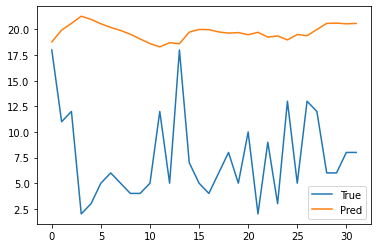

In [357]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)

plt.plot(test_set, label = "True")
plt.plot(y_pred, label = "Pred")

plt.legend()
plt.show()

Retrain model on 100% of data

In [358]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_set = df_new.values

scaler = MinMaxScaler(feature_range=(0,1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1,1))

X_train = []
y_train = []

# observ = 45 #Number of observations to base your prediction on

for i in range(observ, len(train_set_norm)):
  X_train.append(train_set_norm[i-observ:i])
  y_train.extend(train_set_norm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = df_new[-observ:].values 

X_test = scaler.transform(X_test.reshape(-1,1))

X_test = X_test.reshape(1, observ, 1)

print(len(train_set), len(test_set))
print(X_train.shape, y_train.shape)
print(X_test.shape)

325 32
(285, 40, 1) (285,)
(1, 40, 1)


In [359]:
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train,
                    epochs=17,
                    batch_size=72,
                    verbose=1,
                    shuffle=False)

y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)

Epoch 1/17
4/4 [==============================] - 0s 50ms/step - loss: 0.0094
Epoch 2/17
4/4 [==============================] - 0s 52ms/step - loss: 0.0102
Epoch 3/17
4/4 [==============================] - 0s 49ms/step - loss: 0.0081
Epoch 4/17
4/4 [==============================] - 0s 50ms/step - loss: 0.0079
Epoch 5/17
4/4 [==============================] - 0s 47ms/step - loss: 0.0070
Epoch 6/17
4/4 [==============================] - 0s 47ms/step - loss: 0.0068
Epoch 7/17
4/4 [==============================] - 0s 48ms/step - loss: 0.0070
Epoch 8/17
4/4 [==============================] - 0s 46ms/step - loss: 0.0061
Epoch 9/17
4/4 [==============================] - 0s 47ms/step - loss: 0.0065
Epoch 10/17
4/4 [==============================] - 0s 46ms/step - loss: 0.0060
Epoch 11/17
4/4 [==============================] - 0s 48ms/step - loss: 0.0062
Epoch 12/17
4/4 [==============================] - 0s 47ms/step - loss: 0.0061
Epoch 13/17
4/4 [==============================] - 0s 49ms/st

In [360]:
from datetime import datetime
from datetime import timedelta

date = datetime.strptime(df_melt.iloc[-1].ds, '%m/%d/%y') + timedelta(days=1)

# Number of cases tomorrow
num_cases = y_pred[0][0]

if num_cases < 0:
  num_cases = 0

# number of cases tomorrow
print("Number of cases on {} is predicted to be {:.0f}.".format(date.date(), num_cases))

Number of cases on 2020-12-13 is predicted to be 22.
